# Problem 1
## Question
>1) 20 points
>
>Considering the Pauli-Y gate as an observable:
>- Choose an Ansatz (parameterized quantum circuit) that is able to capture the minimum eigenvalu of this observable.
>- Write a function that takes a parameter (float) as input and returns your ansatz as parameterized quntum circuit. (Use Qiskit)

# Solution
I choose the x-rotation gate $R_x(\theta)$ as the ansatz. 

In [65]:
#Define imports
import numpy as np
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter

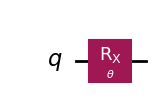

In [66]:
op = SparsePauliOp('Y')

def rot_x(theta):
    _qc = QuantumCircuit(1)
    _qc.rx(theta,0)
    return _qc

theta = Parameter("$\\theta$")
rotx_circ = rot_x(theta)
rotx_circ.draw("mpl")

# Problem 2
## Question
>2) 20 points
>
>Visualize the problem landscape:
>- evaluate the expectation value for the Pauli-Y observable and your choice of Ansatz for various parameters.
>The plot should depict the input parameters on the x-axis and the respective expectation value on the y axis.
>(Use Qiskit).
>- For what parameter is the expectation value minimal? Does that match your solution from p-set 3? (Answere in text.)
>
>Hint: 100 parameters ranging from 0 to 4 $\pi$ should capture your problem landscape adequately.

In [67]:
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

In [68]:
import matplotlib.pyplot as plt
import matplotlib.ticker as tck

import warnings
warnings.simplefilter(action='ignore')

In [69]:
with open("../../api_key.txt",'r') as f:
    token = f.read()


service = QiskitRuntimeService(channel='ibm_quantum',token=token)
real_backend = service.backend('ibm_brisbane')
sim_backend = AerSimulator.from_backend(real_backend)

In [70]:
phases = np.linspace(0, 4*np.pi, 100)
individual_phases = [[ph] for ph in phases]

pm = generate_preset_pass_manager(backend=sim_backend, optimization_level=3)
ansatz = rotx_circ
isa_ansatz = pm.run(ansatz)
isa_ops = op.apply_layout(layout=isa_ansatz.layout)

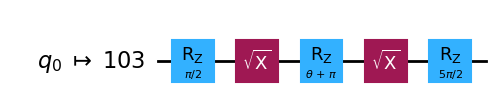

In [71]:
isa_ansatz.draw("mpl",idle_wires=False)

In [72]:
isa_ops

SparsePauliOp(['IIIIIIIIIIIIIIIIIIIIIIIYIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII'],
              coeffs=[1.+0.j])

In [ ]:
pub = (isa_ansatz, isa_ops, individual_phases)
with Session(backend=sim_backend) as session:
    estimator = EstimatorV2(mode=session)
    result_landscape = estimator.run([pub]).result()
    
def plot_expect_landscape(phases,result_landscape,params=None,energy_list=None):
    values = result_landscape[0].data.evs
    plt.plot(phases/np.pi, values, label=r'$E= \langle 0| R_x^{\dagger}(\theta) Z  R_x(\theta) |0 \rangle$')
    if params != None and energy_list != None:
        plt.plot(np.array(params)/np.pi,energy_list,'o',label='Optimizer')
    plt.title(r'Expectation value $<\psi(\theta)|Z|\psi(\theta)>$ with variation in $\theta$')
    ax = plt.gca()
    ax.grid(True)
    ax.xaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
    ax.xaxis.set_major_locator(tck.MultipleLocator(base=1/2))
    plt.xlabel(r'$\theta$')
    plt.ylabel(r'$<\psi(\theta)|Z|\psi(\theta)>$')
    plt.legend()
    plt.show()

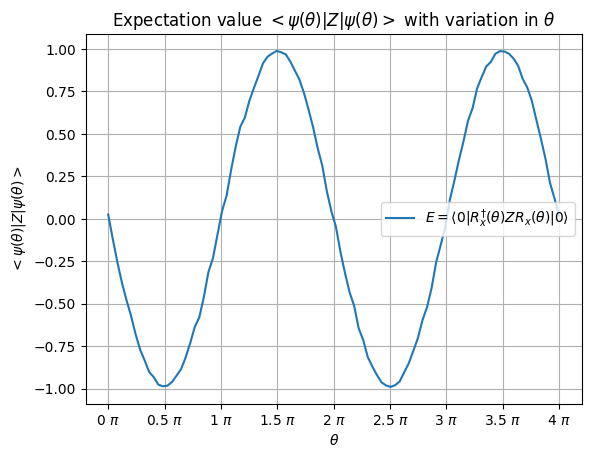

In [74]:
plot_expect_landscape(phases,result_landscape)

In [75]:
min_exp_value = np.round(min(result_landscape[0].data.evs), 1)
min_exp_value

-1.0

The minimum expected value using the estimator was approximately $-1$ which occurs at $\frac{\pi}{2}$ and $\frac{5\pi}{2}$ on the interval $[0,4\pi]$. This means that the minimum expected value occurs for all
$$
\theta = \frac{\pi}{2} + 2\pi n,\quad \forall n = \dots,-2,-1,0,1,2,\dots
$$

This aligns with my proposed Ansatz from problem 3:
$$
\ket{\psi(\theta)} = R_{x}(\theta)\ket{0} = \cos\left(\frac{\theta}{2}\right)\ket{0} - i\sin\left(\frac{\theta}{2}\right)\ket{1},
$$

which if you calculate find the expected value, you end up with
$$
\bra{\psi(\theta)}\sigma_{y}\ket{\psi(\theta)} = -\sin(\theta),
$$

which, as you can see, is the graph of the expected value above.

# Problem 3
## Question
>3) 60 points
>
>Choosing the Pauli-Y gate as your observable: Write your custom VQE routine to infer the minimal eigenvalue of this observable with your choice of Ansatz. (Use Qiskit)
>
>Feel free to experiment with different optimizers and respective hyperparameters

In [87]:
from qiskit_algorithms.optimizers import SPSA

In [88]:
# Define the VQE routine to infer the minimal expectation value
def custom_vqe_estimator(estimator,ansatz,ops,optimizer=None,initial_point=None):
    energy_list = []
    param_list = []
    
    #Objective function is the expectation value E = <psi(theta)|OPS|psi(theta)>
    def objective_function(params):
        # The cost is the expectation value of the observable

        # Your code goes here:
        # Use the pub pattern and extract the result of the expectation value as `cost`
        pub = (ansatz,ops,params)
        result = estimator.run([pub]).result()
        cost = result[0].data.evs

        
        
        print(f'Backend: {estimator.mode.backend()} - Cost: {cost}')
        return cost
    
    # Call back function
    def callback(x,fx,ax,tx,nx):
    # Callback function to get a view on internal states and statistics of the optimizer for visualization
        energy_list.append(ax)
        param_list.append(fx)
            
    if initial_point is None:
        initial_point = np.random.random(ansatz.num_parameters)

    # Define optimizer and pass callback function
    if optimizer == None:
        optimizer = SPSA(maxiter=10, callback=callback)
        
    # The optimizer should minimize the objective_function fun starting from initial_point x0
    result = optimizer.minimize(fun=objective_function,x0=initial_point)

    return  param_list, energy_list, result  

In [89]:
with Session(service=service, backend=sim_backend) as session:
    estimator = EstimatorV2(mode=session)
    param_list_sim, energy_list_sim, result = custom_vqe_estimator(estimator=estimator,
                                                               ansatz=isa_ansatz, 
                                                               ops=isa_ops,)
params_sim = [p[0] for p in param_list_sim]

Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.7763671875
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.4501953125
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.4482421875
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.7626953125
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.478515625
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.7490234375
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.45166015625
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.7490234375
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.7685546875
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.4375
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.435546875
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.7451171875
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.75732421875
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.4482421875
Backend: aer_simulator_from(ibm_brisbane) - Cost: -0.76806640625
Backend: aer_simulator_from(ibm_brisbane) - C

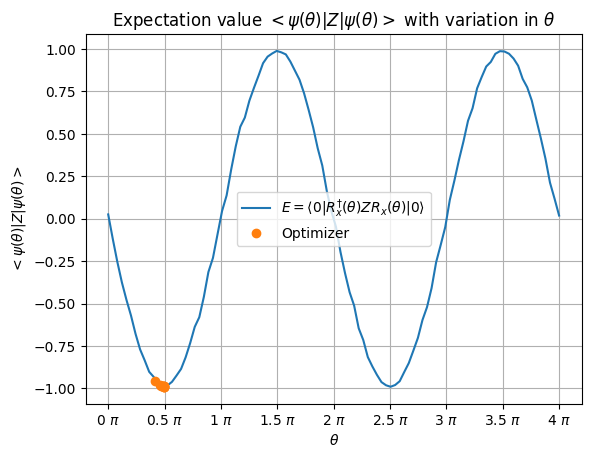

In [90]:
plot_expect_landscape(phases,result_landscape,params_sim,energy_list_sim)